In [ ]:
%pip install opencv-python scikit-image imutils

In [ ]:
import cv2
import numpy as np
from skimage.measure import regionprops, label

# Load image
image = cv2.imread("data/mm_paper_with_fragments.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply edge detection to find grid lines
edges = cv2.Canny(gray, 50, 150)
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=50, maxLineGap=5)

# Find pixel distances between detected grid lines
grid_spacing = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(y2 - y1) < 5:  # Detect horizontal lines
            grid_spacing.append(y1)
grid_spacing.sort()

# Estimate mm per pixel based on grid line spacing
if len(grid_spacing) > 1:
    avg_spacing_pixels = np.mean(np.diff(grid_spacing))  # Average distance between lines
    mm_per_pixel = 1 / avg_spacing_pixels
else:
    mm_per_pixel = 0.1  # Fallback estimate if grid detection fails

# Apply thresholding to isolate fragments
_, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Measure fragment sizes using region properties
labeled_image = label(thresh)
props = regionprops(labeled_image)

# Output fragment sizes
for i, region in enumerate(props):
    area_mm2 = region.area * (mm_per_pixel ** 2)
    print(f"Fragment {i + 1}: {area_mm2:.2f} mm²")

# Show image with contours
cv2.drawContours(image, contours, -1, (0, 255, 0), 2)   
cv2.imshow("Detected Fragments", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import cv2
import numpy as np
from skimage.measure import regionprops, label

# Load image
image = cv2.imread("data/mm_paper_with_fragments_small.jpg")
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define HSV range for red color detection (adjust if needed)
lower_red1 = np.array([0, 120, 70])    # Lower boundary for red tones
upper_red1 = np.array([10, 255, 255])  # Upper boundary for red tones
lower_red2 = np.array([170, 120, 70])  # Handling the upper range of red
upper_red2 = np.array([180, 255, 255])

# Create masks to detect red grid lines
mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
red_mask = mask1 + mask2  # Combine both red masks 

# Create masks for red and brown tones
mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)

# Combine masks for red & brown grid lines
grid_mask = mask_red1 + mask_red2 + mask_brown

# Detect grid lines using edge detection on red mask
edges = cv2.Canny(grid_mask, 50, 150)
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=50, maxLineGap=5)

# Compute mm-per-pixel ratio from detected grid lines
grid_spacing = []
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if abs(y2 - y1) < 5:  # Detect horizontal red grid lines
            grid_spacing.append(y1)
grid_spacing.sort()

# Estimate mm per pixel based on grid spacing
if len(grid_spacing) > 1:
    avg_spacing_pixels = np.mean(np.diff(grid_spacing))  # Average distance between grid lines
    mm_per_pixel = 1 / avg_spacing_pixels
else:
    mm_per_pixel = 0.1  # Fallback estimate if detection fails

# Convert original image to grayscale for fragment analysis
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding to isolate fragments **excluding red grid areas**
_, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
thresh[grid_mask > 0] = 0  # Remove grid pixels from the thresholded image

# Find contours of fragments
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Measure fragment sizes using region properties
labeled_image = label(thresh)
props = regionprops(labeled_image)

# Output fragment sizes
for i, region in enumerate(props):
    area_mm2 = region.area * (mm_per_pixel ** 2)
    print(f"Fragment {i + 1}: {area_mm2:.2f} mm²")

# Show image with detected contours
cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
cv2.imshow("Detected Fragments", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [12]:
import cv2
import numpy as np
from skimage.measure import regionprops, label

# Load image
image = cv2.imread("data/roasted_coffee_bean_sizing.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (7, 7), 0) #pyimagesearch

# Apply thresholding to detect contours
_, thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find squares based on shape properties
square_centers = {}
other_contours = []
for cnt in contours:
    approx = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
    if len(approx) == 4:  # Detect quadrilateral shapes
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = float(w) / h
        if 0.9 < aspect_ratio < 1.1:  # Ensure square-like dimensions
            square_centers[(x + w // 2, y + h // 2)] = (w,h)
    else:
        other_contours.append(cnt)

# Ensure exactly 4 calibration squares detected
#if len(square_centers) != 4:
#    print("Error: Could not reliably detect all 4 calibration squares.")
    #exit()

# Sort squares into top-left, top-right, bottom-left, bottom-right
square_centers_sorted = sorted(square_centers, key=lambda p: (p[1], p[0]))
top_left, top_right = square_centers_sorted[:2]
bottom_left, bottom_right = square_centers_sorted[-2:]

# Compute mm-per-pixel ratios using known 1 cm reference
horizontal_scale_tl = 10 / square_centers[top_left][0]
vertical_scale_tl = 10 / square_centers[top_left][1]
horizontal_scale_tr = 10 / square_centers[top_right][0]
vertical_scale_tr = 10 / square_centers[top_right][1]
horizontal_scale_bl = 10 / square_centers[bottom_left][0]
vertical_scale_bl = 10 / square_centers[bottom_left][1]
horizontal_scale_br = 10 / square_centers[bottom_right][0]
vertical_scale_br = 10 / square_centers[bottom_right][1]
horizontal_scale = (horizontal_scale_tl+horizontal_scale_tr+horizontal_scale_bl+horizontal_scale_br)/4 # mean
vertical_scale = (vertical_scale_tl+vertical_scale_tr+vertical_scale_bl+vertical_scale_br)/4 # mean

# Convert scale factors into distortion correction model
def local_scale(x, y):
    """Compute mm-per-pixel correction based on distance to reference squares."""
    weights = [
        1 / np.linalg.norm(np.array([x, y]) - np.array(top_left)),
        1 / np.linalg.norm(np.array([x, y]) - np.array(top_right)),
        1 / np.linalg.norm(np.array([x, y]) - np.array(bottom_left)),
        1 / np.linalg.norm(np.array([x, y]) - np.array(bottom_right)),
    ]
    weights = np.array(weights) / np.sum(weights)  # Normalize weights
    return (
        (horizontal_scale_tl * weights[0] + horizontal_scale_tr * weights[1] + horizontal_scale_bl * weights[2] + horizontal_scale_br * weights[3])*
        (vertical_scale_tl * weights[0] + vertical_scale_tr * weights[1] + vertical_scale_bl * weights[2] + vertical_scale_br * weights[3])
    )

# Detect objects within the main region
#thresh[thresh == 255] = 0  # Remove calibration squares
objects = label(thresh)
props = regionprops(objects)

# Measure objects with distortion-aware calibration
fragment_sizes = []
for i, region in enumerate(props):
    center_x, center_y = region.centroid
    if (center_x,center_y) in square_centers:
        print('Reference region')
    scale_factor = local_scale(center_x, center_y)
    area_mm2 = region.area * scale_factor
    fragment_sizes.append(area_mm2)
    #print(f"Fragment {i + 1}: {area_mm2:.2f} mm²")

    # Put area on object
    cv2.putText(
        image, "{:.1f}mm2".format(area_mm2),
		(int(region.centroid[1]), int(region.centroid[0])), cv2.FONT_HERSHEY_SIMPLEX,
		0.65, (255, 255, 255), 2
    )
    
    # Get bounding box coordinates (min row, min col, max row, max col)
    minr, minc, maxr, maxc = region.bbox
    cv2.rectangle(image, (minc, minr), (maxc, maxr), (0, 255, 255), 2)  # Draw yellow box

# Show detected objects and calibration squares
cv2.drawContours(image, contours, -1, (0, 255, 0), 2)
for x, y in square_centers:
    cv2.circle(image, (x, y), 5, (255, 0, 0), -1)

cv2.namedWindow("Processed Image", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Processed Image", 800, 600)
cv2.imshow("Processed Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

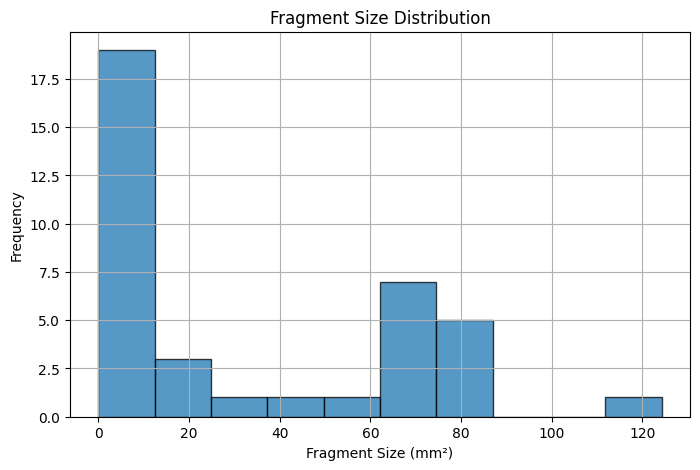

In [13]:
import matplotlib.pyplot as plt

# Plot fragment size distribution
plt.figure(figsize=(8, 5))
plt.hist(fragment_sizes, bins=10, edgecolor='black', alpha=0.75)
plt.xlabel("Fragment Size (mm²)")
plt.ylabel("Frequency")
plt.title("Fragment Size Distribution")
plt.grid(True)
plt.show()